In [669]:
import gc # сборщик мусора

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
import numpy as np 
import pandas as pd 
import random
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import pairwise_distances
from lightgbm import LGBMRegressor


In [670]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [671]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [672]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 5)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [673]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

#**Загрузка данных**

In [674]:
df = pd.read_csv('Data set to train.csv')
df.head(10)



,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,5088,-118.28,33.98,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN,121400.0
1,17096,-122.23,37.46,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN,363700.0
2,5617,-118.26,33.79,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN,205600.0
3,20060,-119.26,35.87,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND,47600.0
4,895,-121.96,37.54,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN,236000.0
5,19653,-120.85,37.49,39.0,2840.0,733.0,2606.0,737.0,1.9429,INLAND,76400.0
6,18403,-121.84,37.24,24.0,7991.0,1286.0,4017.0,1213.0,5.4741,<1H OCEAN,238800.0
7,11307,-117.94,33.78,40.0,299.0,68.0,163.0,70.0,3.0125,<1H OCEAN,166100.0
8,1225,-120.43,38.25,13.0,763.0,161.0,311.0,125.0,2.4583,INLAND,112500.0
9,6408,-118.03,34.13,33.0,2352.0,373.0,995.0,359.0,4.9583,INLAND,445700.0


In [675]:
X = df.drop('median_house_value', axis=1)
y = df[['Id ', 'median_house_value']]

X.set_index('Id ', inplace=True)
y.set_index('Id ', inplace=True)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
5088,-118.28,33.98,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN
17096,-122.23,37.46,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN
5617,-118.26,33.79,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN
20060,-119.26,35.87,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND
895,-121.96,37.54,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN


In [676]:
X_final = pd.read_csv('Data set to test X.csv')

'''first_q = df.quantile(q=0.15)
third_q = df.quantile(q=0.99)

IQR = third_q-first_q
outliers = X_final[(X_final>(third_q+1.5*IQR))|(X_final<(first_q-1.5*IQR))].count(axis=1)
outliers.sort_values(axis=0, ascending = False, inplace=True)

outliers = outliers.head(19)
X_final.drop(outliers.index,inplace = True)'''
X_final.set_index('Id ', inplace=True)
final_index_list = X_final.index

In [677]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 1.05 MB
Memory usage after optimization is: 0.54 MB
Decreased by 48.7%


In [678]:
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.52 MB
Memory usage after optimization is: 0.27 MB
Decreased by 48.7%


#**Exploratory Data Analysis**

                    longitude  latitude  ...  households  median_income
longitude            1.000000 -0.009715  ...    0.039350      -0.003205
latitude            -0.009715  1.000000  ...    0.006354      -0.018312
housing_median_age  -0.039775 -0.011278  ...   -0.302934      -0.115285
total_rooms          0.035243  0.005695  ...    0.920828       0.197146
total_bedrooms       0.043869  0.006314  ...    0.981101      -0.010957
population           0.060158  0.006036  ...    0.904587       0.002590
households           0.039350  0.006354  ...    1.000000       0.010560
median_income       -0.003205 -0.018312  ...    0.010560       1.000000

[8 rows x 8 columns]


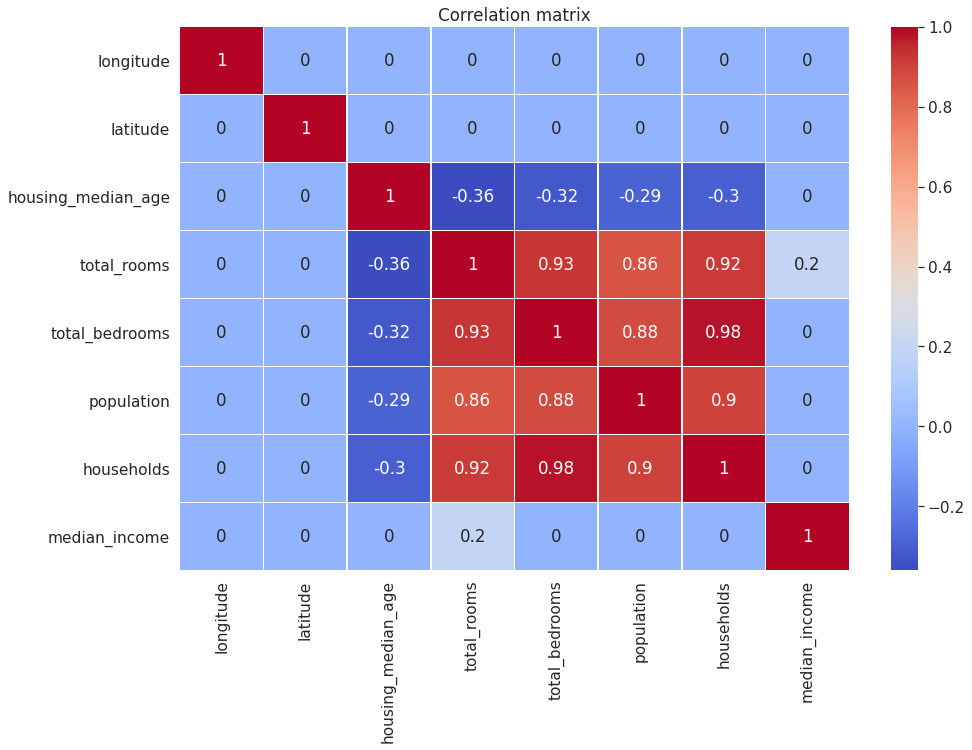

In [679]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
print(X.corr())
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0 

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [680]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,13828.000000,13828.000000,13349.000000,13828.000000,13828.000000,13429.000000,13828.000000,13828.000000
mean,-119.489861,34.763271,28.569706,2647.572998,540.267151,1430.852661,501.675446,3.876735
std,4.857742,115.936920,12.583060,2171.663818,421.248840,1148.826538,383.638641,1.903102
min,-124.349998,-13534.030273,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.809998,33.939999,18.000000,1455.000000,297.000000,791.000000,280.000000,2.568575
50%,-118.510002,34.270000,29.000000,2139.000000,437.000000,1168.000000,412.000000,3.538750
75%,-118.010002,37.720001,37.000000,3166.000000,648.000000,1732.000000,607.000000,4.756600
max,121.290001,1327.130005,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100


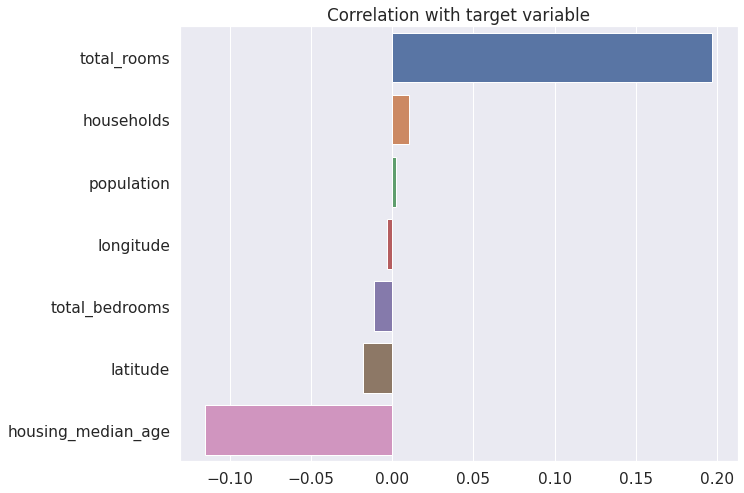

In [681]:
corr_with_target = X.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [682]:
base_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


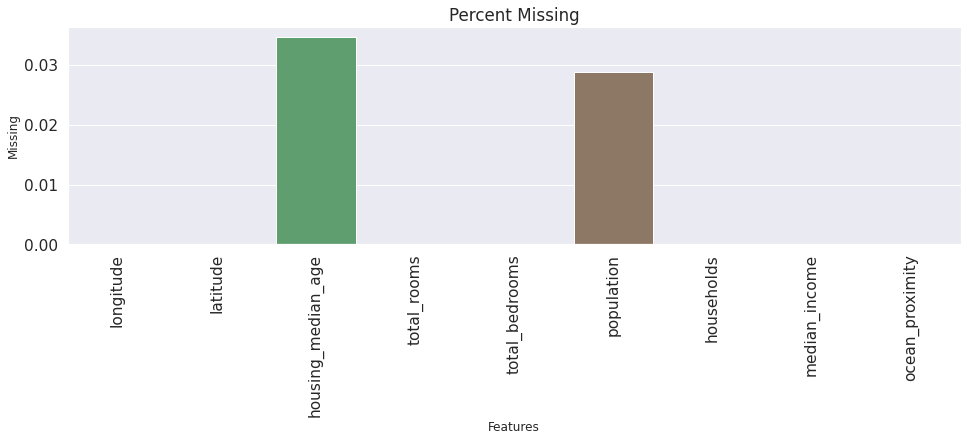

In [683]:
nan_analize(X)

# **Анализируем и исправляем**

In [684]:
median = X['housing_median_age'].median()
X['housing_median_age'] = X['housing_median_age'].fillna(median)
X_final['housing_median_age'] = X_final['housing_median_age'].fillna(median)

In [685]:
median = X['population'].median()
X['population'] = X['population'].fillna(median)
X_final['population'] = X_final['population'].fillna(median)

In [686]:
X.loc[X['longitude'] > 0, 'longitude'] = X.loc[X['longitude'] > 0, 'longitude'] * -1


X_final.loc[X_final['longitude'] > 0, 'longitude'] = X_final.loc[X_final['longitude'] > 0, 'longitude'] * -1


In [687]:
X['population_per_room'] = X['population'] / X['total_rooms']
X_final['population_per_room'] = X_final['population'] / X_final['total_rooms']

In [688]:

X['dist_to_tr'] = -(+0.70*X['longitude']+X['latitude']+(100))/(0.70**2 + 1)**0.5
X_final['dist_to_tr'] = (-0.61*X_final['longitude']-X_final['latitude']-(96.168))/(0.616**2 + 1)**0.5

In [689]:

X['dist_to_bank'] = (-0.79*X['longitude']-X['latitude']-127.8)/1.28
X_final['dist_to_bank'] = (-0.79*X_final['longitude']-X_final['latitude']-127.8)/1.28

In [690]:


X['dist_to_SC'] = ((X['longitude']+122)**2+(X['latitude']-36.9744)**2)**0.5
X_final['dist_to_SC'] = ((X_final['longitude']+122)**2+(X_final['latitude']-36.9744)**2)**0.5

In [691]:


X['dist_to_SM'] = ((X['longitude']+122.33)**2+(X['latitude']-37.5444)**2)**0.5
X_final['dist_to_SM'] = ((X_final['longitude']+122.33)**2+(X_final['latitude']-37544)**2)**0.5

In [692]:

X['dist_to_LA'] = ((X['longitude']+118)**2+(X['latitude']-33)**2)**0.5
X_final['dist_to_LA'] = ((X_final['longitude']+118)**2+(X_final['latitude']-33)**2)**0.5

In [693]:
X['dist_to_SF'] = ((X['longitude']+123)**2+(X['latitude']-37.7272)**2)**0.5
X_final['dist_to_SF'] = ((X_final['longitude']+123)**2+(X_final['latitude']-37.7272)**2)**0.5

In [694]:

X['min_dist'] = np.minimum(X['dist_to_LA'], X['dist_to_SF'])
X_final['min_dist'] = np.minimum(X_final['dist_to_LA'], X_final['dist_to_SF'])

In [695]:
X['rooms_per_bedroom'] = X['total_rooms'] / X['total_bedrooms']
X_final['rooms_per_bedroom'] = X_final['total_rooms'] / X_final['total_bedrooms']

In [696]:
X['population_per_room'] = X['population'] /( X['total_rooms'])
X_final['population_per_room'] = X_final['population'] /( X_final['total_rooms'])

In [697]:
X['d_m'] = X['dist_to_bank']/X['min_dist']
X_final['d_m'] = X_final['dist_to_bank']/X_final['min_dist']

#**Проверка модели**

In [698]:
remain_features = ['longitude','d_m','min_dist','dist_to_LA','dist_to_SC','latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households','median_income', 'population_per_room', 'dist_to_bank','rooms_per_bedroom','ocean_proximity']

X = X[remain_features]
X_final = X_final[remain_features]

In [699]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [700]:
model = LGBMRegressor(max_depth=15,
                             min_samples_leaf=5,
                             n_estimators=250,
                             random_state=42)
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=5,
              min_split_gain=0.0, n_estimators=250, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

R2:	0.84735
RMSE:	44909.044
MSE:	2016822239.91


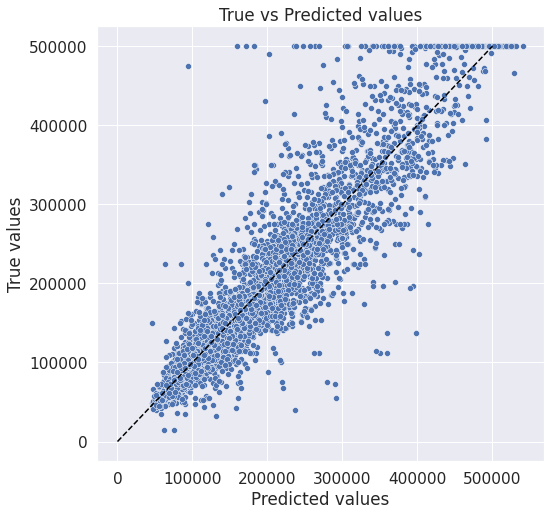

In [701]:
y_pred_test = model.predict(X_test)
evaluate_preds(y_test['median_house_value'], y_pred_test)

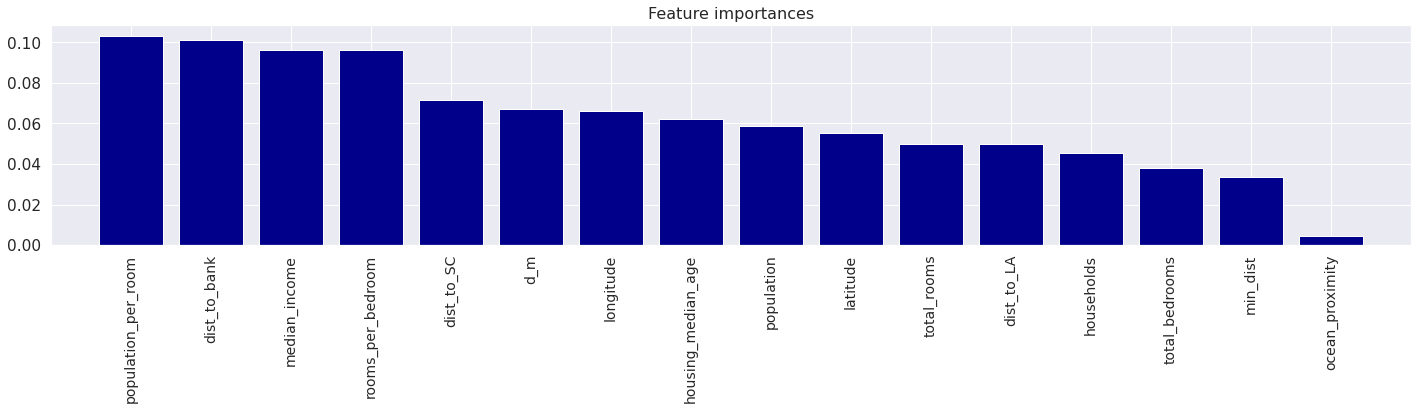

In [702]:
plot_feature_importances(importances = model.feature_importances_, X=X)

# **Учим финальную модель**

In [703]:
model_lgbm_f = LGBMRegressor(max_depth=15,
                             min_samples_leaf=5,
                             n_estimators=250,
                             random_state=42)
model_lgbm_f.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=5,
              min_split_gain=0.0, n_estimators=250, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [704]:
y_pred_test = model_lgbm_f.predict(X_final)
y_pred_df = pd.DataFrame(y_pred_test, columns=['median_house_value'])

'''
a = y_pred_test.tolist().copy()

print(len(a))
a = np.concatenate((a,a[-1:-20:-1]), axis=0)


df = pd.DataFrame(a, columns=['median_house_value'])
df
'''



"\na = y_pred_test.tolist().copy()\n\nprint(len(a))\na = np.concatenate((a,a[-1:-20:-1]), axis=0)\n\n\ndf = pd.DataFrame(a, columns=['median_house_value'])\ndf\n"

In [705]:
filename = '201203_Danchenkov_2.csv'
y_pred_df.to_csv(filename, index=None)